## Radio interferometría y síntesis de imágenes en astronomía - Laboratorio 1
### Vicente Mieres

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta, timezone
import juliandate as jd

## Funciones y utilidades

### Funciones principales

In [83]:
def ecef_to_enu(ecef, array_center, phi=-33.45, lamb=-70.66, rad=True, is_array=True):
  '''
  ecef in meters (xyz)
  array_center: central antenna coords
  phi: latitud
  lamb (lambda): longitude
  rad: True if phi and lambd need to be radians
  '''
  if rad:
      phi, lamb = np.deg2rad(phi), np.deg2rad(lamb)

  cphi, clam = np.cos(phi), np.cos(lamb)
  sphi, slam = np.sin(phi), np.sin(lamb)


  R = np.array([[-slam,        clam,       0],
                [-clam*sphi,   -slam*sphi, cphi],
                [clam*cphi,    slam*cphi,  sphi]])

  dxyz = np.array(ecef) - np.array(array_center)

  enu = R @ dxyz.T if is_array else R @ dxyz

  return enu


def enu_to_altaz(enu, rad=True, is_array=True):
  '''
  Transform the enu vector to altitude and azimut
  '''

  if is_array:
    E, N, U = enu[0], enu[1], enu[2]
  else:
    E, N, U = float(enu[0]), float(enu[1]), float(enu[2])

  r = np.hypot(E, N)           
  El = np.arctan2(U, r)
  A = np.arctan2(E, N)
  
  if rad:
      return El, A % (2*np.pi)
  else:
      A_deg = np.degrees(A) % 360.0
      El_deg = np.degrees(El)
      return El_deg, A_deg

def local_sidereal_time(longitude=-70.76, utc=None, single=True):
  """
  Calculates the local sidereal time in Radians.
  """
  if utc is None:
    now = datetime.now(timezone.utc)
  else:
    now = utc

  jd_now = jd.from_gregorian(now.year, now.month, now.day, now.hour, now.minute, now.second)
  T = (jd_now - 2451545.0) / 36525
  theta = 280.46061837 + 360.98564736629 * (jd_now - 2451545) + (0.000387933 * T * T) - (T * T * T / 38710000.0)
  deg = theta % 360 + longitude

  h,m,s = degree_to_time(deg)
  rad = np.deg2rad(deg)
  
  if single: 
    return rad 
  else: 
    return deg, rad, h, m, s

def degree_to_time(theta, is_rad=False):
  """
  Converts degrees to hours, minutes and seconds.
  """
  if is_rad:
    theta = np.rad2deg(theta)

  h = int(theta/ 15)
  m = (int)(((theta / 15) - h) * 60)
  s = ((((theta / 15) - h) * 60) - m) * 60
  return h, m, s

def Rz(theta):
  c, s = np.cos(theta), np.sin(theta)
  return np.array([[ c, -s, 0],
                   [ s, c, 0],
                   [ 0, 0, 1]])

def Ry(theta):
  c, s = np.cos(theta), np.sin(theta)
  return np.array([[ c, 0, s],
  [ 0, 1, 0],
  [-s, 0, c]])


def hor_to_eq(enu, alt, az, phi=-33.45):
    """
    Convierte un baseline ENU en coordenadas ecuatoriales (X, Y, Z),
    equivalente a baseline_to_XYZ().

    Parámetros
    ----------
    enu : array (..., 3)
        Coordenadas de baselines en el sistema local (E, N, U)
    alt, az : array o float
        Ángulos de elevación y acimut de la fuente (radianes)
    phi : float
        Latitud del observatorio (radianes)
    Retorna
    -------
    r_eq : array (..., 3)
        Coordenadas ecuatoriales (X, Y, Z)
    """
    phi = np.radians(phi)

    # Convertir a np.array y asegurar forma (...,3)
    enu = np.asarray(enu)
    if enu.shape[-1] != 3:
        raise ValueError("El array ENU debe tener forma (..., 3)")

    # Separar componentes
    E, N, U = enu[..., 0], enu[..., 1], enu[..., 2]

    # Norma del baseline
    b_norm = np.sqrt(E**2 + N**2 + U**2)

    # Calcular X, Y, Z (idéntico a baseline_to_XYZ)
    X = b_norm * ( np.sin(alt)*np.cos(phi) - np.cos(alt)*np.sin(phi)*np.cos(az) )
    Y = b_norm * ( np.sin(az)*np.cos(alt) )
    Z = b_norm * ( np.sin(alt)*np.sin(phi) + np.cos(alt)*np.cos(phi)*np.cos(az) )

    return np.stack([X, Y, Z], axis=-1)


def eq_to_uvw(H, delta, hor_coords, is_array=True):
  '''
  Return the uvw coords of an antenna o antenna array 
  '''
  ch, cd = np.cos(H), np.cos(delta)
  sh, sd = np.sin(H), np.sin(delta)

  R = np.array([[sh,        ch,      0],
                [-sd*ch,   sd*sh,   cd],
                [cd*ch,   -cd*ch,   sd]])
  
  uvw = hor_coords @ R.T if is_array else R @ hor_coords

  return uvw

def baselines(enu):
  '''
  Return all combinations of baselines
  '''
  enu = np.asarray(enu)
  N = len(enu)

  # Matriz completa de diferencias (N, N, 3)
  diff = enu[:, None, :] - enu[None, :, :]

  # Evitar la diagonal (i == j)
  mask = ~np.eye(N, dtype=bool)
  baselines = diff[mask].reshape(-1, 3)

  return baselines

def eq_to_uvw_array(H_array, delta, r_eq):
    """
    Aplica la rotación (Ecuación 4) a todos los baselines y horas ángulo.
    r_eq: (N_baselines, 3)
    H_array: (N_H,)
    delta: float (rad)
    Retorna: uvw (N_baselines, N_H, 3)
    """
    cd, sd = np.cos(delta), np.sin(delta)
    ch, sh = np.cos(H_array), np.sin(H_array)

    # Matrices de rotación para cada H  → forma (N_H, 3, 3)
    R = np.stack([
        np.stack([sh,        ch,        np.zeros_like(H_array)], axis=-1),
        np.stack([-sd*ch,    sd*sh,     np.full_like(H_array, cd)], axis=-1),
        np.stack([cd*ch,    -cd*sh,     np.full_like(H_array, sd)], axis=-1)
    ], axis=-2)  # axis=-2 -> (N_H, 3, 3)
    
    uvw = np.einsum('hij,bj->bhi', R, r_eq)  # (N_baselines, N_H, 3)

    return uvw

def ra_dec_to_radians(radec, is_ra=True):
  """
  Converts right ascension and declination to Radians.
  """
  h, m, s = map(float, (radec.split(':')))
  
  value = abs(h) + m / 60 + s / 3600
  if is_ra:
    degrees = value * 15
  else:
    degrees = value if h >= 0 else -value
  return np.deg2rad(degrees)


def uvw_to_lambda(uvw, freq_hz):
    """
    Convierte las coordenadas UVW de metros a longitudes de onda (λ).
    """
    c = 299792458.0  # velocidad de la luz (m/s)
    lam = c / freq_hz
    uvw_lambda = uvw / lam
    return uvw_lambda, lam

def plot_uv_coverage(
    uvw,
    unit="m",
    freq_hz=100e9,
    title=None,
    show_symmetry=True,
    show_center=True,
    center_color="white",
    center_size=50,
    color="deepskyblue",
    symmetry_color=None,
    cmap=None,
    color_by=None
):
    """
    Grafica la cobertura (u,v) para diferentes unidades y opciones de color.

    Parámetros
    ----------
    uvw : array (..., 3)
        Coordenadas UVW en metros.
    unit : str
        Unidad del gráfico: "m", "km" o "lambda".
    freq_hz : float
        Frecuencia (solo usada si unit="lambda").
    title : str
        Título opcional del gráfico.
    show_symmetry : bool
        Si True, grafica también la parte negativa (-u, -v).
    show_center : bool
        Si True, muestra un punto central.
    center_color : str
        Color del punto central.
    center_size : int
        Tamaño del punto central.
    color : str o array
        Color base de los puntos (nombre o array numérico).
    symmetry_color : str
        Color de la simetría (por defecto más tenue del color base).
    cmap : str
        Colormap opcional si `color_by` es numérico.
    color_by : array (...,)
        Array para colorear los puntos según algún valor (por ejemplo, hora angular).
    """
    # --- Selección de unidades ---
    if unit == "m":
        scale = 1.0
        label = "[m]"
    elif unit == "km":
        scale = 1e-3
        label = "[km]"
    elif unit.lower() in ["λ", "lambda", "wavelength"]:
        uvw, lam = uvw_to_lambda(uvw, freq_hz)
        scale = 1.0
        label = "[λ]"
    else:
        raise ValueError("Unidad no reconocida. Usa 'm', 'km' o 'lambda'.")

    # --- Extraer u,v ---
    u = uvw[..., 0] * scale
    v = uvw[..., 1] * scale

    # --- Determinar color ---
    if symmetry_color is None:
        # Genera un color más oscuro para la parte simétrica
        if isinstance(color, str):
            symmetry_color = "royalblue" if color == "deepskyblue" else color
        else:
            symmetry_color = color

    # --- Crear figura ---
    plt.figure(figsize=(6, 6))

    # Si se quiere colorear por una variable
    if color_by is not None:
        sc = plt.scatter(u.flatten(), v.flatten(), c=color_by.flatten(),
                         s=2, cmap=cmap or "viridis", label="Baselines")
        plt.colorbar(sc, label="Color variable")
    else:
        plt.plot(u.flatten(), v.flatten(), ".", markersize=1, color=color, label="Baselines")

    if show_symmetry:
        plt.plot(-u.flatten(), -v.flatten(), ".", markersize=1,
                 alpha=0.4, color=symmetry_color, label="Simetría conjugada")

    # --- Punto central ---
    if show_center:
        plt.scatter(0, 0, color=center_color, s=center_size, zorder=5)

    plt.xlabel(f"u {label}")
    plt.ylabel(f"v {label}")
    plt.axis("equal")
    plt.grid(alpha=0.2)
    plt.legend(markerscale=5, fontsize=8, loc="upper right")

    if title:
        plt.title(title)
    else:
        plt.title(f"Cobertura UV ({unit})")

    plt.show()


def H_range(ra_rad, utc_start, utc_end, longitude=-70.76, step_minutes=5):
    """
    Calcula una serie de Hora Angular (H) física entre dos fechas UTC.

    Parámetros
    ----------
    ra_rad : float
        Ascensión recta de la fuente en radianes.
    utc_start : str o datetime
        Fecha/hora de inicio (ej: "2025-10-10 00:00:00").
    utc_end : str o datetime
        Fecha/hora de fin (ej: "2025-10-10 06:00:00").
    longitude : float
        Longitud del observatorio (grados, Oeste negativo).
    step_minutes : float
        Paso temporal entre muestras en minutos.
    """

    # --- Parsear las fechas si vienen como strings ---
    if isinstance(utc_start, str):
        utc_start = datetime.fromisoformat(utc_start).replace(tzinfo=timezone.utc)
    if isinstance(utc_end, str):
        utc_end = datetime.fromisoformat(utc_end).replace(tzinfo=timezone.utc)

    # --- Crear el rango de tiempos ---
    n_steps = int((utc_end - utc_start).total_seconds() / 60 / step_minutes) + 1
    times_utc = [utc_start + timedelta(minutes=i * step_minutes) for i in range(n_steps)]

    # --- Calcular LST para cada instante ---
    lst_rad = np.array([
        local_sidereal_time(longitude=longitude, utc=t, single=True)
        for t in times_utc
    ])

    # --- Calcular H = LST - RA ---
    H = lst_rad - ra_rad

    # --- Envolver a (-π, π] ---
    H = (H + np.pi) % (2 * np.pi) - np.pi

    return times_utc, H, lst_rad


### Funciones secundarias

In [84]:
# utilidades 

def read_cfg_to_enu(filename, array_center=None ,phi=-33.44, lamb=-70.76, rad=True):
  '''
  Read file and return antenna config on ENU coords
  '''
  with open(filename, "r") as f:
    lines = f.readlines()

  coordsys = None 
  for line in lines:
        if line.startswith("# coordsys"):
            coordsys = line.split("=")[1].strip()
            break
  
  antennas = []
  for line in lines:
      if line.startswith("#") or not line.strip():
          continue
      parts = line.split()
      x, y, z = map(float, parts[:3])
      antennas.append([x, y, z])
  antennas = np.array(antennas)

  if coordsys == "LOC (local tangent plane)": return antennas.T
  elif coordsys == "XYZ":
     array_center = array_center if array_center is not None else antennas.mean(axis=0)
     enu_antennas = ecef_to_enu(antennas, array_center, phi, lamb, rad)
     return np.array(enu_antennas)
  else:
    raise ValueError(f"coordsys desconocido: {coordsys}")

import numpy as np
import matplotlib.pyplot as plt

def plot_antennas(enu_coords, labels=True, title="Configuración de Antenas", unit="m"):
    """
    Muestra la configuración de antenas a partir de sus coordenadas ENU.

    Parámetros
    ----------
    enu_coords : ndarray (N,3)
        Arreglo con las coordenadas [E, N, U] de cada antena (en metros).
    labels : bool
        Si True, muestra el índice de cada antena en el gráfico.
    title : str
        Título del gráfico.
    unit : {"m", "km"}
        Unidad en la que se mostrarán las coordenadas en el gráfico.
        Siempre se asume que enu_coords está en metros internamente.
    """

    enu_coords = np.array(enu_coords)

    # --- Conversión de unidades ---
    if unit == "m":
        scale = 1
        unit_label = "m"
    elif unit == "km":
        scale = 1e-3
        unit_label = "km"
    else:
        raise ValueError(f"Unidad desconocida: {unit}. Usa 'm' o 'km'.")

    E, N, U = enu_coords[:, 0] * scale, enu_coords[:, 1] * scale, enu_coords[:, 2] * scale

    # --- Gráfico ---
    fig = plt.figure(figsize=(12, 6))

    # Vista en planta (E-N)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(E, N, c='black', marker='o')
    if labels:
        for i, (e, n) in enumerate(zip(E, N)):
            ax1.text(e, n, str(i), fontsize=9, ha='right')
    ax1.set_xlabel(f"East [{unit_label}]")
    ax1.set_ylabel(f"North [{unit_label}]")
    ax1.set_title("Vista en planta (E-N)")
    ax1.grid(True)
    ax1.axis('equal')

    # Vista en perfil (N-U)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(N, U, c='darkblue', marker='o')
    if labels:
        for i, (n, u) in enumerate(zip(N, U)):
            ax2.text(n, u, str(i), fontsize=9, ha='right')
    ax2.set_xlabel(f"North [{unit_label}]")
    ax2.set_ylabel(f"Up [{unit_label}]")
    ax2.set_title("Vista en perfil (N-U)")
    ax2.grid(True)
    ax2.axis('equal')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



### Catálogo de Fuentes

In [85]:
catalog = {
        'Sirius': {'RA': '06:45:09', 'Dec': '-16:42:58'},
        'Canopus': {'RA': '06:23:57', 'Dec': '-52:41:44'},
        'Centauri': {'RA': '14:39:36', 'Dec': '-60:50:02'},
        'Betelgeuse': {'RA': '05:55:10', 'Dec': '+07:24:25'},
        'Rigel': {'RA': '05:14:32', 'Dec': '-08:12:06'},
        'M31': {'RA': '00:42:44.3', 'Dec': '+41:16:09'},
        'M42': {'RA': '05:35:17.3', 'Dec': '-05:23:28'},
        '47_Tuc': {'RA': '00:24:05', 'Dec': '-72:04:52'},
        'LMC': {'RA': '05:23:35', 'Dec': '-69:45:22'}
    }

## Parte 1 Simulación de cobertura uv

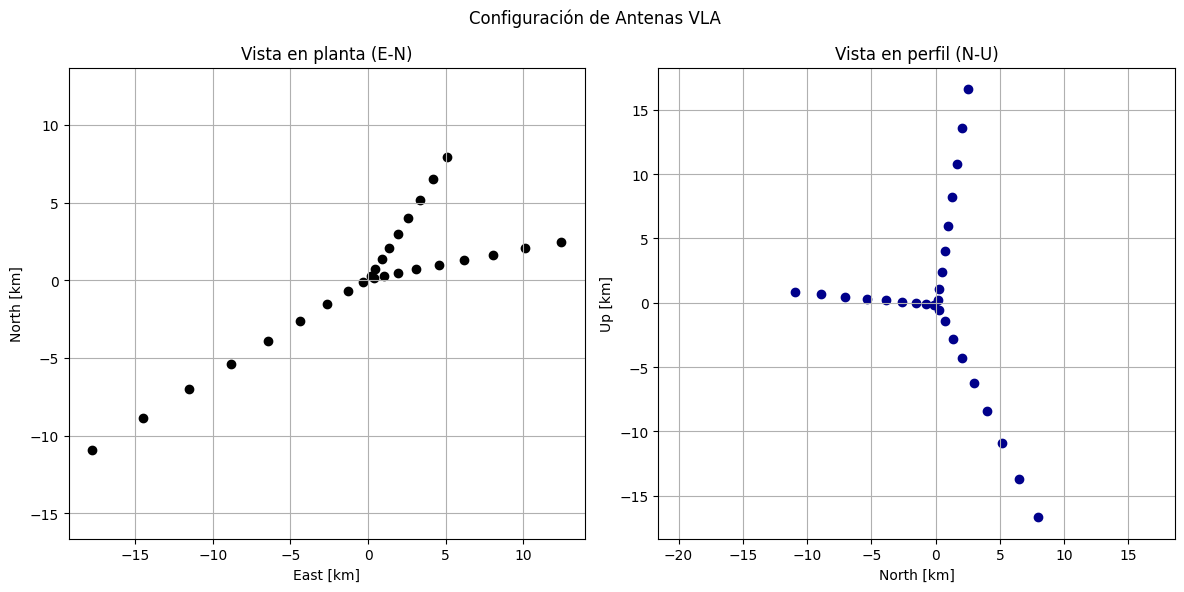

In [86]:
# 1. Lectura de antenas y definición de parámetros del arreglo
# Observatory VLA

latitude = 34.078749
longitude = -107.617728

enu = read_cfg_to_enu("../antenna_arrays/vla.a.cfg")

plot_antennas(enu.T, labels=False, unit="km",title="Configuración de Antenas VLA")

In [87]:
# 2. Obtención de Baselines
baselines_enu = baselines(enu.T) 

print("Baselines: ", baselines_enu.shape)

Baselines:  (702, 3)


In [88]:
# 3. Transformacion baseline -> alt, az (Horizontales) -> XYZ (Ecuatoriales)
alt, az = enu_to_altaz(baselines_enu.T, rad=True)
r_eq = hor_to_eq(baselines_enu, alt, az, phi=latitude)

print("Altitud: ", alt.shape) 
print("Azimut: ", az.shape) 
print("XYZ: ", r_eq.shape) 


Altitud:  (702,)
Azimut:  (702,)
XYZ:  (702, 3)


In [89]:
# 4. Transformación XYZ -> uvw

# Delta fijo -> Sirius
sirius_dec = catalog["Sirius"]['Dec']
sirius_ra = catalog["Sirius"]['RA']
delta_src = ra_dec_to_radians(sirius_dec, is_ra=False)
ra_src = ra_dec_to_radians(sirius_ra)

# Rango de horas angulo
times_utc, H, lst = H_range(
    ra_rad=ra_src,
    utc_start="2025-10-10 00:00:00",
    utc_end="2025-10-10 12:00:00",
    longitude=longitude,
    step_minutes=5
)

# Obtención muestreo
uvw = eq_to_uvw_array(H, delta_src, r_eq)
# uvw_freq = uvw_to_lambda(uvw, )

print("uvw:", uvw.shape)

uvw: (702, 145, 3)


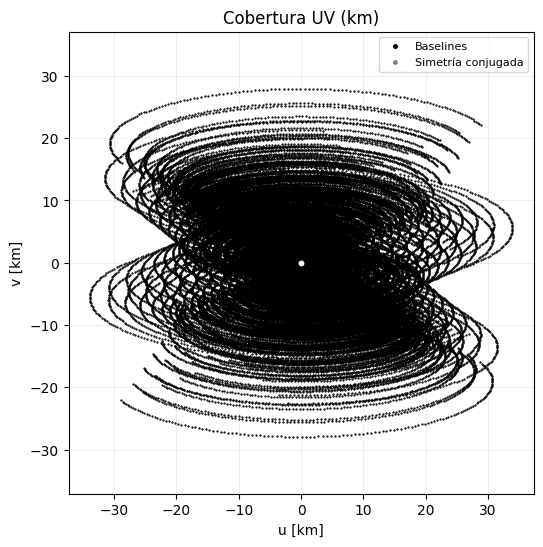

In [90]:
# 5. Gráfico uvw
plot_uv_coverage(uvw, unit='km', show_center=True, color='black', center_size=10)

In [91]:
freq_hz = 100e9
uvw_lambda, _ = uvw_to_lambda(uvw, freq_hz)

print(uvw_lambda.shape)

print(uvw_lambda)

(702, 145, 3)
[[[ -330761.21176166   161935.80790903    20603.60573402]
  [ -329231.55217327   164012.32365294    27517.92873698]
  [ -327544.33679778   166078.71851531    34398.55151671]
  ...
  [  332887.30656453   127145.32513936   -95240.75326169]
  [  331612.31087257   125054.62933494  -102202.29262639]
  [  330178.62046561   122972.45607003  -109135.4538817 ]]

 [[ -809532.08435206   394565.85625843    50203.90950393]
  [ -805804.07380445   399648.14071278    67126.75558069]
  [ -801690.44075632   404705.75391379    83967.45202055]
  ...
  [  814710.27258174   309832.25541434  -231939.62210985]
  [  811605.54363021   304715.42529978  -248977.49734244]
  [  808112.41682096   299619.35451027  -265946.24876553]]

 [[-1417466.89110778   694015.8292682     88247.25603991]
  [-1410912.32316457   702914.67526945   117878.38009304]
  [-1403682.55443907   711770.15320703   147365.09840253]
  ...
  [ 1426577.01431915   544941.76907717  -408135.30524993]
  [ 1421113.80041498   535982.162355

In [92]:
def direction_cosines(ra_rad, dec_rad, ra0_rad, dec0_rad):
    """
    ra_rad, dec_rad: arrays (Nsrc,) or scalars, in radians
    ra0_rad, dec0_rad: scalars (pointing) in radians
    returns l, m, n arrays same shape as ra_rad
    """
    dalpha = ra_rad - ra0_rad
    cosd = np.cos(dec_rad)
    sind = np.sin(dec_rad)
    cosd0 = np.cos(dec0_rad)
    sind0 = np.sin(dec0_rad)

    l = cosd * np.sin(dalpha)
    m = sind * cosd0 - cosd * sind0 * np.cos(dalpha)
    n = sind * sind0 + cosd * cosd0 * np.cos(dalpha)
    return l, m, n

# ---------------- generar visibilidades ----------------
def visibilities_from_sources(uvw_lambda, sources, ra0_deg, dec0_deg, sigma_pb=0.05, freq_hz=None):
    """
    uvw_lambda: (Nvis,3) u,v,w in lambda units
    sources: list of dicts [{'ra_deg':..., 'dec_deg':..., 'S0':...}, ...]
    ra0_deg, dec0_deg: pointing in degrees
    sigma_pb: primary beam sigma (radians)
    returns V_total (Nvis,) complex
    """
    # u,v,w arrays
    u = uvw_lambda[:,0]
    v = uvw_lambda[:,1]
    w = uvw_lambda[:,2]

    # pointing in radians
    ra0 = np.deg2rad(ra0_deg)
    dec0 = np.deg2rad(dec0_deg)

    # Prepare source arrays
    ras = np.array([src['ra_deg'] for src in sources])
    decs = np.array([src['dec_deg'] for src in sources])
    S0s  = np.array([src.get('S0', 1.0) for src in sources])

    ras_rad = np.deg2rad(ras)
    decs_rad = np.deg2rad(decs)

    # Get l,m,n for all sources
    l_src, m_src, n_src = direction_cosines(ras_rad, decs_rad, ra0, dec0)  # shape (Nsrc,)

    # Primary beam (evaluated at source position) -> gaussian circular
    A_src = np.exp(-(l_src**2 + m_src**2) / (2 * sigma_pb**2))  # shape (Nsrc,)

    # For each source compute its visibility vector (vectorized over visibilities)
    # We'll sum contributions: V_total = sum_s A_s * S_s / n_s * exp(2π i (u l_s + v m_s + w (n_s-1)))
    V_total = np.zeros(u.shape, dtype=complex)

    # Loop over sources (Nsrc usually small; loop is fine). If Nsrc large, vectorizar más.
    two_pi_i = 2j * np.pi
    for ls, ms, ns, As, Ss in zip(l_src, m_src, n_src, A_src, S0s):
        phase = two_pi_i * (u * ls + v * ms + w * (ns - 1.0))
        V_s = As * Ss / ns * np.exp(phase)
        V_total += V_s

    # weights omega = 1 (según enunciado)
    omega = np.ones_like(V_total, dtype=float)
    return V_total, omega, l_src, m_src, n_src

# ---------------- ejemplo de uso ----------------
# Supón que uvw_lambda ya está definido (Nvis,3)
# Ejemplo de fuentes: 2 fuentes, una en el centro, otra 0.5 deg al este


def generate_random_sources(ra0_deg, dec0_deg, N=50, max_offset_deg=1.0, flux_range=(0.1, 1.0), seed=None):
    """
    Genera N fuentes puntuales alrededor del centro (ra0, dec0)
    en un radio máximo de max_offset_deg.
    """
    rng = np.random.default_rng(seed)
    ras = ra0_deg + rng.uniform(-max_offset_deg, max_offset_deg, N)
    decs = dec0_deg + rng.uniform(-max_offset_deg, max_offset_deg, N)
    fluxes = rng.uniform(flux_range[0], flux_range[1], N)

    sources = [{"ra_deg": ra, "dec_deg": dec, "S0": S} for ra, dec, S in zip(ras, decs, fluxes)]
    return sources

# --- Ejemplo de uso ---
ra0_deg = 101.2875   # Sirius A
dec0_deg = -16.7161
sources = generate_random_sources(ra0_deg, dec0_deg, N=200, max_offset_deg=1.0, flux_range=(0.2, 1.0), seed=42)

# Ahora puedes pasarlas directo a tu función:
V, omega, l_src, m_src, n_src = visibilities_from_sources(uvw_lambda, sources, ra0_deg, dec0_deg)

print(f"Simuladas {len(sources)} fuentes puntuales.")

# amp = np.log1p(np.abs(V))
# phase = np.angle(V)

# plt.figure(figsize=(8,4))
# plt.imshow(amp, aspect='auto', origin='lower')
# plt.colorbar(label='Amplitude')
# plt.title('Amplitude of V (2 sources)')
# plt.xlabel('frequency index')
# plt.ylabel('baseline index')

# plt.figure(figsize=(8,4))
# plt.imshow(phase, aspect='auto', origin='lower', cmap='twilight')
# plt.colorbar(label='Phase [rad]')
# plt.title('Phase of V (2 sources)')
# plt.xlabel('frequency index')
# plt.ylabel('baseline index')
# plt.show()


# plt.figure(figsize=(6,6))
# plt.scatter([s["ra_deg"] for s in sources], [s["dec_deg"] for s in sources],
#             c=[s["S0"] for s in sources], cmap="plasma", s=50)
# plt.gca().invert_xaxis()  # RA aumenta hacia la izquierda en astronomía
# plt.xlabel("RA [deg]")
# plt.ylabel("Dec [deg]")
# plt.title("Fuentes puntuales simuladas")
# plt.colorbar(label="Flujo S₀")
# plt.show()


Simuladas 200 fuentes puntuales.


In [93]:
print(uvw_lambda.shape)

(702, 145, 3)


uvw_lambda shape: (101790, 3)
V shape: (101790,)
(101790,)


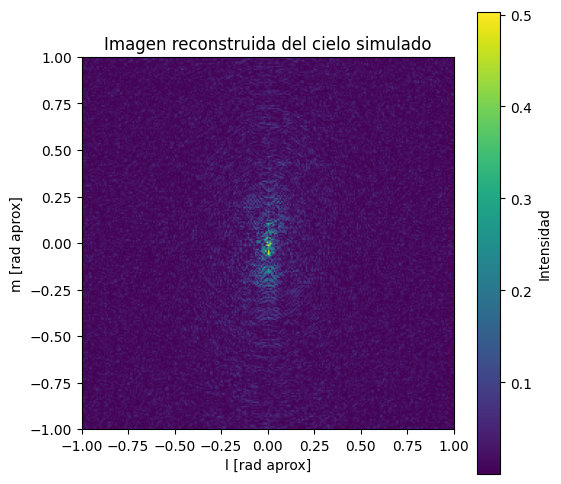

In [95]:
from scipy.interpolate import griddata

def grid_visibilities(V, uvw_lambda, Npix=256):
    """
    Gridding simple de visibilidades (u,v) en una grilla regular 2D.
    """

    print("uvw_lambda shape:", uvw_lambda.shape)
    print("V shape:", V.shape)

    
    u = uvw_lambda[:,0]
    v = uvw_lambda[:,1]
    V_flat = V.flatten()
    print(V_flat.shape)

    u_max = np.max(np.abs(u))
    v_max = np.max(np.abs(v))

    # Grilla regular
    u_grid = np.linspace(-u_max, u_max, Npix)
    v_grid = np.linspace(-v_max, v_max, Npix)
    U, Vv = np.meshgrid(u_grid, v_grid)

    # Interpolación: griddata asigna valores complejos a la grilla
    V_grid = griddata((u, v), V_flat, (U, Vv), method='nearest', fill_value=0.0+0.0j)
    return V_grid, u_grid, v_grid


# Aplanar uvw_lambda en (702*145, 3)
uvw_flat = uvw_lambda.reshape(-1, 3)

# Tomar sólo u y v
u = uvw_flat[:, 0]
v = uvw_flat[:, 1]

# Expandir visibilidades a la misma cantidad de puntos
# Si tus V tienen 3 frecuencias, repetimos cada baseline 145 veces
V_expanded = np.repeat(V, 145, axis=0)

# Si solo quieres una frecuencia (por ejemplo, la primera):
V_flat = V_expanded[:, -1]  # o promedio en caso de querer una sola imagen

V_grid, u_grid, v_grid = grid_visibilities(V_flat, uvw_flat, Npix=256)

from numpy.fft import ifftshift, fftshift, ifft2

# Transformada inversa
image = fftshift(ifft2(ifftshift(V_grid)))
intensity = np.log1p(np.abs(image))

plt.figure(figsize=(6,6))
plt.imshow(intensity, origin='lower', cmap='viridis',
           extent=[-1,1,-1,1])
plt.xlabel('l [rad aprox]')
plt.ylabel('m [rad aprox]')
plt.title('Imagen reconstruida del cielo simulado')
plt.colorbar(label='Intensidad')
plt.show()


In [ ]:
import numpy as np

def grid_visibilities_manual(V, uvw_lambda, Npix=256):
    """
    Implementa el gridding según el enunciado del laboratorio.
    
    Parámetros:
        V: visibilidades complejas, shape (N_baselines, N_horas)
        uvw_lambda: coordenadas (u,v,w), shape (N_baselines, N_horas, 3)
        Npix: tamaño de la grilla (NxN)
    
    Retorna:
        VG: grilla compleja de visibilidades
        WG: matriz de pesos
        u_grid, v_grid: coordenadas de la grilla
    """
    u = uvw_lambda[..., 0].flatten()
    v = uvw_lambda[..., 1].flatten()
    V_flat = V.flatten()

    # rango máximo de u y v
    u_max = np.max(np.abs(u))
    v_max = np.max(np.abs(v))

    # grilla regular (centrada)
    u_grid = np.linspace(-u_max, u_max, Npix)
    v_grid = np.linspace(-v_max, v_max, Npix)

    du = u_grid[1] - u_grid[0]
    dv = v_grid[1] - v_grid[0]

    # matrices de acumulación
    VG = np.zeros((Npix, Npix), dtype=complex)
    WG = np.zeros((Npix, Npix), dtype=float)

    # pesos (todos 1 según el laboratorio)
    omega = np.ones_like(V_flat)

    # Loop principal: acumula visibilidades
    for k in range(len(V_flat)):
        i = int(np.round(u[k] / du)) + Npix // 2
        j = int(np.round(v[k] / dv)) + Npix // 2

        # verifica que caiga dentro de la grilla
        if 0 <= i < Npix and 0 <= j < Npix:
            VG[j, i] += omega[k] * V_flat[k]  # nota: eje y corresponde a filas
            WG[j, i] += omega[k]

    # normalización
    mask = WG > 0
    VG[mask] /= WG[mask]

    return VG, WG, u_grid, v_grid


# V = simulate_point_source_visibilities(uvw_lambda)  # o tus visibilidades reales

VG, WG, u_grid, v_grid = grid_visibilities_manual(V, uvw_lambda, Npix=256)

VG

C:\Users\vicen\AppData\Local\Temp\ipykernel_20164\1519657427.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  WG[j, i] += omega[k]


array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      shape=(256, 256))

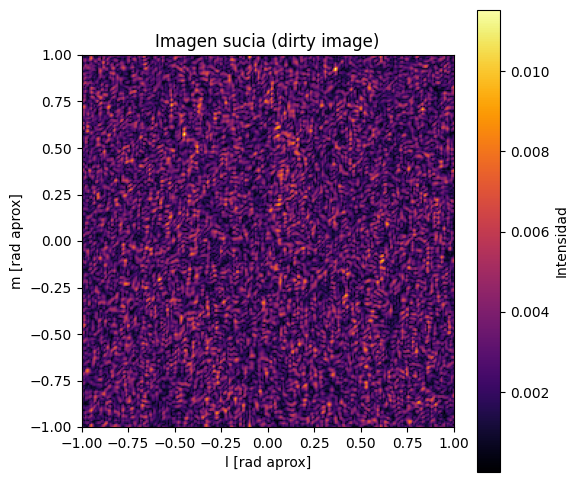

In [97]:
from numpy.fft import fftshift, ifftshift, ifft2

image = fftshift(ifft2(ifftshift(VG)))
intensity = np.log1p(np.abs(image))

plt.figure(figsize=(6,6))
plt.imshow(intensity, origin='lower', cmap='inferno', extent=[-1,1,-1,1])
plt.xlabel('l [rad aprox]')
plt.ylabel('m [rad aprox]')
plt.title('Imagen sucia (dirty image)')
plt.colorbar(label='Intensidad')
plt.show()
